# Trabajo de minería de datos

**Asignatura: Análisis de datos e invesgitación en historia política y social**

**Alumno: Juan Luis Font Calvo**


Réplica del estudio del trabajo *“Analysis of Teacher Training in Mathematicsin   Paraguay’s Elementary Education System Using Machine Learning Techniques"*.

## Introducción del problema
Los conjuntos de datos estudiados en esta práctica corresponden a una encuesta realizada por el gobierno de Paraguay entre profesores de matemáticas de 216 localidades con el fin de identificar posibles necesidades sobre su formación y habilidades pedagógicas. 

El objetivo de la práctica es aplicar minería de datos y *machine learning* a este conjunto de datos de forma que sea posible determinar si un docente necesita formación de refuerzo en base al cuestionario de evaluaciónde sus capacidades docentes y pedagógicas.


## Descripción de los atributos del conjunto de datos
La encuesta está compuesta por 17 preguntas (17 atributos o *features*), identificadas como P01, P02, ..., P17.

Un conjunto de las preguntas tienen como respuesta valores numéricos (*numeric attribute*), mientras que otras toman sólo un número limitado de posibles respuestas (*factor attribute*).

El siguiente listado detalla el tipo de valores asociados a cada una de las preguntas. En el caso de las preguntas de tipo *factor* se detalla el dominio de posibles valores que toma el atributo para cada una de las observaciones.
```
P01 {Satisfactorio,Insipiente,Ninguno}
P02 {Satisfactorio,Insipiente,Ninguno}
P03 {Mucho,Poco}
P04 {Regular,Suficiente,Insipiente}
P05 {Suficiente,Insipiente,Regular}
P06 {Suficiente,Insipiente,Regular}
P07 {Insipiente,Satisfactorio,Ninguno}
P08 {Mucho,Poco,Nada}
P09 numeric
P10 numeric
P11 numeric
P12 numeric
P13 numeric
P14 numeric
P15 numeric
P16 {Mucho,Poco}
P18 {Si,No}
P19 {Conceptual,Procedimental}
P17 {Sí,'Más o menos'}
```

### Atributo clasificador / *classifier*
La pregunta *P17*, *"¿Los alumnos docentes comprenden las diferentes estructuras que deben tener los tipos de evaluación para el mejoramiento de la tarea docente en el área de Matemática?*, es el atributo usado para clasificar las observaciones y decidir si el sujeto de la encuesta necesita o no algún tipo de refuerzo para mejorar posibles carencias en su formación.

El objetivo de la práctica es entrenar diversos modelos que en función del resto de respuestas al cuestionario sean capaces de evaluar con cierta fiabilidad si el docente evaluado requiere formación de refuerzo.

### Herramientas de análisis
El análisis de los datos se ha realizado en lenguaje R. El código y la documentación están contenidos en el presente [*Jupyter notebook*](https://jupyter.org).

La biblioteca `RWeka` para lenguaje R proporciona *bindings* para librerías desarrolladas incialmente en Java para la herramienta de minería de datos [Weka](https://www.cs.waikato.ac.nz/ml/weka/), como por ejemplo funciones para lectura de archivos `.arff`, o selección de *features*. En otras ocasiones se optado por usar implementaciones nativas en R equivalentes a los algoritmos de machine learning disponibes en Weka (i.e. Naïve Bayes o J48).

### Carga de los datos
La carga de datos depende de la función `read.arff` proporcionada por la librería `RWeka`.

La variable `class.attr` contiene el nombre del atributo clasificador del problema, la pregunta *P17*.

El conjunto de datos `data.total`, combinación de los subconjuntos de datos 1, 2 y 3, contiene un atributo extra, `NEtapa`. Este atributo no corresponde con ninguna de las preguntas del cuestionario y debe ser eliminado para evitar que introduzca ruído en los modelos durante el proceso de entrenamiento.


In [1]:
library(RWeka)

# attribute for classification 
class.attr <- "P17"

# seed for the whole notebook
seed <- 3017

data.d1 <- read.arff("dataset/dataset_etapas_class17_idx1.arff");
data.d2 <- read.arff("dataset/dataset_etapas_class17_idx2.arff");
data.d3 <- read.arff("dataset/dataset_etapas_class17_idx3.arff");

# remove NEtapa attribute
data.total <- read.arff("dataset/dataset_etapas_class17_idx.arff");
data.attributes <- names(data.total)
data.attributes <- data.attributes[data.attributes != "NEtapa"]
data.total <- data.total[data.attributes]

# convenient list including all the datasets
datasets <- list(data.d1, data.d2, data.d3, "total"=data.total)

## Análisis de la homogeneidad



### Ranking de atributos

Este apartado recoge el cálculo del raking de los atributos para cada uno de los conjuntos de datos basándose en su correlación con respecto al atributo de clasificación *P17*. Esta ordenación se realiza con la función `symmetrical.uncertainty()`, proporcionada por la librería `RWeka`.

Una vez calculado el coeficiente de ranking para cada uno de los subconjuntos 1, 2 y 3 y el conjunto *total*, los atributos se ordenan en función a los coeficientes obtenidos para el conjunto de datos total y a continuación se representan gráficamente.

Si los datos son homogéneos entre los distintos subconjuntos, es decir, las respuestas a las encuentas siguen patrones similares independientemente de la región donde se obtuvieron, se puede afirmar que los datos muestran homogeneidad. En el caso de que encontremos grandes diferencias en los rankings obtenidos para cada una de las regiones, será un indicio de que los resultados no son homogéneos entre distintas regiones, cada una de ellas mostrando unos patrones distintos al resto.

In [2]:
library(RWeka)
library(FSelector)

# list without the classification attribute / P17
data.attributes.rank <- data.attributes[data.attributes != class.attr]

# let's initialize the dataframe with the attributes to be ranked
results <- data.frame(question=data.attributes.rank)

# ranking formula
form.rank <- as.formula(paste(class.attr, "~.", sep=''))

# iteration over the 3 sub-datasets
for (i in seq(1,3)){
    # get attributes minus P17
    df <- datasets[[i]][data.attributes]
    # calculate weights
    weights <- symmetrical.uncertainty(form.rank, df)
    # add a new column for the sub-dataset
    d.name <- paste("d", i, sep='')
    results[[d.name]] <- weights$attr_importance
}
# calculate rank for dataset "total"
df <- datasets[["total"]][data.attributes]
weights <- symmetrical.uncertainty(form.rank, df)
results[["total"]] <- weights$attr_importance

# sort based on "total" column
ranking <-results[order(results$total, decreasing = TRUE),]

### Ranking

La siguiente tabla muestra el resultado de coeficientes de ranking para cada uno de los conjuntos de datos, ordenados en función de los resultados obtenidos para el conjunto de datos *total*.

Conjuntos de datos:
* `d1`: dataset 1
* `d2`: dataset 2
* `d3`: dataset 3
* `total`: dataset resultante de combinar `d1`, `d2` y `d3`

In [3]:
print(ranking)

   question           d1           d2           d3       total
16      P16 1.970815e-01 0.1216236706 0.1948705180 0.178880159
2       P02 8.576754e-02 0.1945140291 0.1574870928 0.136294605
1       P01 1.595718e-01 0.1066124435 0.1267708001 0.133642615
11      P11 2.105397e-01 0.0000000000 0.0000000000 0.107572119
7       P07 1.482383e-01 0.1033461859 0.1516790045 0.106397261
12      P12 0.000000e+00 0.0000000000 0.0000000000 0.098787182
9       P09 0.000000e+00 0.1884341765 0.0000000000 0.096605778
13      P13 0.000000e+00 0.0000000000 0.0000000000 0.086124227
17      P18 9.186946e-02 0.1276441580 0.0089874904 0.061581731
8       P08 1.662741e-01 0.0601835270 0.0039449206 0.054744966
4       P04 4.243235e-02 0.1029642234 0.0463433230 0.050183610
5       P05 3.678905e-02 0.0986573025 0.0087864201 0.041516837
6       P06 9.110573e-03 0.1220306255 0.0069867783 0.032043067
3       P03 6.915974e-02 0.0005793417 0.0007318079 0.012895805
18      P19 8.984024e-05 0.0388085074 0.0002060199 0.00

### Representación gráfica de la homogeneidad

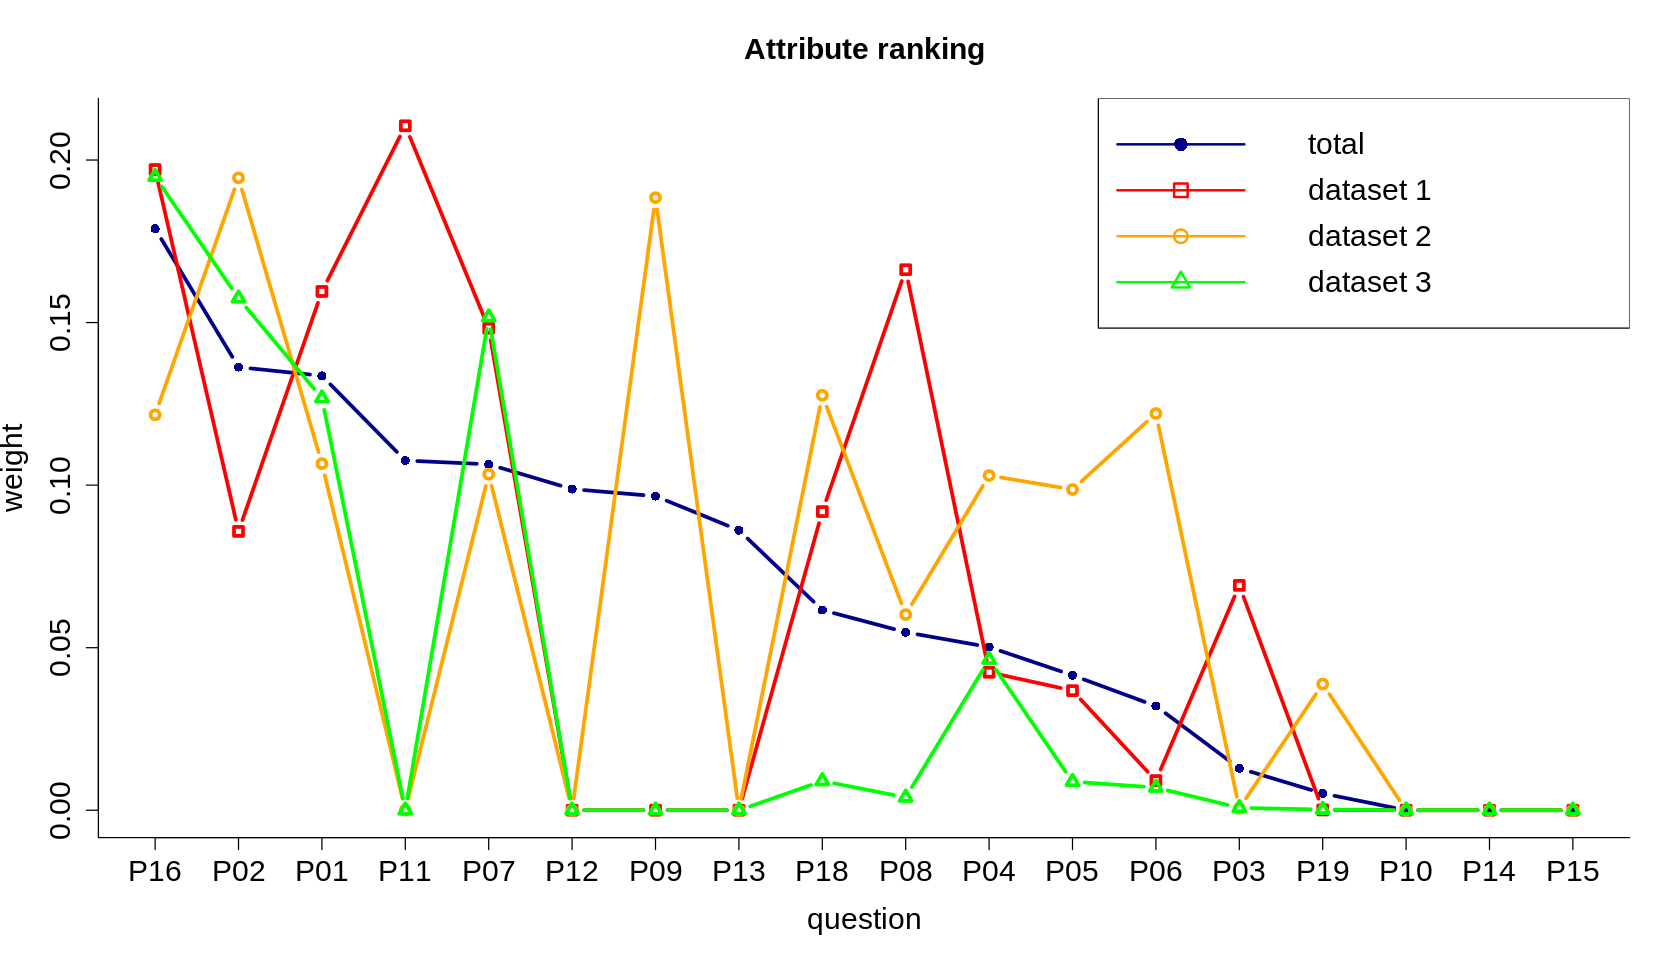

In [4]:
ymax <- max(apply(ranking[ , -1], 1, max, na.rm=TRUE))
ylim <- c(0, ymax)

options(repr.plot.width=14, repr.plot.height=8)

#scaling up fonts

plot(ranking$total,
    cex.lab=1.5, 
    cex.axis=1.5,
    cex.main=1.5,
    cex.sub=1.5,
    main = "Attribute ranking",
    xlab = "question",
    ylab = "weight",
    type = "b",
    pch = 16,
    lwd = 3,
    col = "darkblue",
    xaxt = "n",
    bty="L",
    ylim = ylim)

axis(1, 
     at=seq(length(ranking$question)), 
     labels=ranking$question,
     cex.axis=1.5
    )

lines(ranking$d1, type="b", pch=0, lwd=3, col="red")
lines(ranking$d2, type="b", pch=1, lwd=3, col="orange")
lines(ranking$d3, type="b", pch=2, lwd=3, col="green")

legend("topright",
       legend=c("total", "dataset 1", "dataset 2", "dataset 3"),
       col=c("darkblue", "red", "orange", "green"), 
       lty=1,
       lwd=2,
       pch=c(16, 0, 1, 2),
       cex=1.5)

### Conclusión sobre homogeneidad de los datos

La gráfica `Attribute ranking` del apartado anterior muestra los distintos valores de ranking obtenidos para los subconjuntos y conjunto total de datos en relación al atributo de clasificación *P17*.

El gráfico muestra que ciertas preguntas muestran una correlación homogénea con respecto a *P17* a través de todas las distintas regiones, como por ejemplo *P16*, *P10*, *P14* o *P15*.

En otros casos, preguntas como *P11*, *P09* o *P08* presentan coeficientes en el ranking muy distintos entre sí dependiendo del subconjunto de datos.

## Entrenamiento de modelos de clasificación

Estudio de la capacidad de predecir si los docentes están o no bienpreparados.

Para ello pruebe con los algoritmos Naive Bayes, IbK y J48

### Funciones R para entrenar modelos
TODO
* kfolds
* cálculo de resultado

### Código para entrenar modelo IBk
Se ha usado la función `IBk` proporcionada la librería `RWeka`, una colección de *bindings* que permiten usar las funciones en Java del proyecto Weka.

In [5]:
library(caret);
library(RWeka);

#######
# IBk #
#######

#' Train a IBk model to classify based on \code{class.attr} atribute,
#' using cross-validation.
#' 
#' @param data A data frame where each column is an attribute
#' @param kfolds Number of folds for cross-validation
#' @param class.attr Name of the classifier attribute
#' @return List with the hits and misses from each fold plus their mean and sd
#'     res$hit Vector with the percentage of successful predictions for each fold
#'     res$err Vector with the percentage of wrong predictions for each fold
#'     res$hit.mean Mean of successful predictions across folds
#'     res$hit.sd Standard deviation for successful predictions across folds     
#'     res$err.mean Mean of wrong predictions across folds
#'     res$err.sd Standard deviation for wrong predictions across folds
#' @examples
#' taining.ibk(data.total, 10, "P17")
training.ibk <- function(data, kfolds, class.attr){
    
    folds <- createFolds(data[,1], k=kfolds, list=TRUE);
    
    form <- formula(paste(class.attr, "~ ."))
    
    data.attributes <- colnames(data)
    data.attributes.learn <- data.attributes[data.attributes != class.attr]
    
    res <- list()
    res$hit <- rep(NA, kfolds);
    res$err <- rep(NA, kfolds);
    
    for (i in 1:kfolds){
        # i-th set for testing
        test <- data[unlist(folds[i]), ]
        # remaining sets for training
        train <- data[unlist(folds[-i]), ]
    
        # from RWeka
        # https://cran.r-project.org/web/packages/RWeka/index.html
        model <- IBk(form, data=train)
        # prediction using model and test subset
        pred <- predict(model, newdata=test)
        # confusion matrix
        cm <- table(test[[class.attr]], pred)
        
        res$hit[i] <- sum(diag(cm))/sum(cm)
        res$err[i] <- 1 - res$hit[i]
    }
    
    res$hit.mean <- mean(res$hit)
    res$err.mean <- mean(res$err)
    
    res$hit.sd <- sd(res$hit)
    res$err.sd <- sd(res$err)
    
    return(res)
}

Loading required package: lattice

Loading required package: ggplot2



### Código para entrenar modelo Naïve Bayes

In [6]:
library(e1071);
library(caret);

###############
# Naive Bayes #
###############

#' Train a Naïve Bayes model to classify based on \code{class.attr} atribute,
#' using cross-validation.
#' 
#' @param data A data frame where each column is an attribute
#' @param kfolds Number of folds for cross-validation
#' @param class.attr Name of the classifier attribute
#' @return List with the hits and misses from each fold plus their mean and sd
#'     res$hit Vector with the percentage of successful predictions for each fold
#'     res$err Vector with the percentage of wrong predictions for each fold
#'     res$hit.mean Mean of successful predictions across folds
#'     res$hit.sd Standard deviation for successful predictions across folds     
#'     res$err.mean Mean of wrong predictions across folds
#'     res$err.sd Standard deviation for wrong predictions across folds
#' @examples
#' taining.naive.bayes(data.total, 10, "P17")
training.naive.bayes <- function(data, kfolds, class.attr){
    
    folds <- createFolds(data[,1], k=kfolds, list=TRUE);
    
    form <- formula(paste(class.attr, "~ ."))
    
    data.attributes <- colnames(data)
    data.attributes.learn <- data.attributes[data.attributes != class.attr]
    
    res <- list()
    res$hit <- rep(NA, kfolds);
    res$err <- rep(NA, kfolds);
    
    for (i in 1:kfolds){
        # i-th set for testing
        test <- data[unlist(folds[i]), ]
        # remaining sets for training
        train <- data[unlist(folds[-i]), ]

        model <- naiveBayes(form, train)
        pred <- predict(model, newdata=test) 
        cm <- table(test[[class.attr]], pred) 
        
        res$hit[i] <- sum(diag(cm))/sum(cm)
        res$err[i] <- 1 - res$hit[i]
    }
    
    res$hit.mean <- mean(res$hit)
    res$err.mean <- mean(res$err)
    
    res$hit.sd <- sd(res$hit)
    res$err.sd <- sd(res$err)
    
    return(res)
}

### Código para entrenar modelo J48 / C50

`J48` es la implementación en Java del algoritmo *C4.5*. La librería de R `C50` proporciona una implementación equivalente a `J48`.

La función `C5.0` tiene problemas con caracteres de texto especiales (i.e. vocales acentuadas) y espacios en blanco en los valores de tipo *factor*.

In [7]:
library(C50)
library(caret);

########################
# C5.0 ~ J48 from Weka #
########################

#' Train a C5.0 model to classify based on \code{class.attr} atribute,
#' using cross-validation. C5.0 is the closes to the J48 Java-based
#' implementation provided by Weka project.
#' 
#' @param data A data frame where each column is an attribute
#' @param kfolds Number of folds for cross-validation
#' @param class.attr Name of the classifier attribute
#' @return List with the hits and misses from each fold plus their mean and sd
#'     res$hit Vector with the percentage of successful predictions for each fold
#'     res$err Vector with the percentage of wrong predictions for each fold
#'     res$hit.mean Mean of successful predictions across folds
#'     res$hit.sd Standard deviation for successful predictions across folds     
#'     res$err.mean Mean of wrong predictions across folds
#'     res$err.sd Standard deviation for wrong predictions across folds
#' @examples
#' taining.c50(data.total, 10, "P17")
training.c50 <- function(data, kfolds, class.attr){
    
    folds <- createFolds(data[,1], k=kfolds, list=TRUE);
        
    data.attributes <- colnames(data)
    data.attributes.learn <- data.attributes[data.attributes != class.attr]
    
    res <- list()
    res$hit <- rep(NA, kfolds);
    res$err <- rep(NA, kfolds);
    
    for (i in 1:kfolds){
        # i-th set for testing
        test <- data[unlist(folds[i]), ]
        # remaining sets for training
        train <- data[unlist(folds[-i]), ]

        # we need to remove class attr. / P17 from training set
        train.c50 <- train[data.attributes.learn]
    
        # get class. attribute column / P17
        # empty spaces and accents ARE a problem
        train.class <- sapply(train[[class.attr]], gsub, pattern="Sí", replacement="si")
        train.class <- sapply(train.class, gsub, pattern="Más o menos", replacement="mas_o_menos")
        # we need factor outcome for the model
        train.class <- as.factor(train.class)
    
        # test class. attribute needs same pre-processing
        test.class <- sapply(test[[class.attr]], gsub, pattern="Sí", replacement="si")
        test.class <- sapply(test.class, gsub, pattern="Más o menos", replacement="mas_o_menos")
        # we need factor outcome for the model
        test.class <- as.factor(test.class)
    
        model <- C5.0(train.c50, train.class, rules=TRUE)
        pred <- predict(model, newdata=test)
        cm <- table(test.class, pred)
        
        res$hit[i] <- sum(diag(cm))/sum(cm)
        res$err[i] <- 1 - res$hit[i]
    }
    
    res$hit.mean <- mean(res$hit)
    res$err.mean <- mean(res$err)
    
    res$hit.sd <- sd(res$hit)
    res$err.sd <- sd(res$err)
    
    return(res)
}

## Precisión de los modelos entrenados con todos los atributos

### Predicción con IBk, todos los atributos

In [38]:
set.seed(seed)
kfolds <- 10
ibk.all <- training.ibk(data.total, kfolds, "P17")

#' Generate a string with a summary of the results 
#' generated by the \code{training.*} functions above.
#'
#' @param alg String with the model used, e.g. IBk
#' @param attr String with attributes used for training
#' @param kfolds Number of folds used in cross-validation
#' @param res List with results generated by \code{training.*} functions
#' @return Multi-line string with result summary
#'
#' @examples
#' show.results('IBk, 'all attributes, 10, ibk.total)
show.results <- function(alg, attr, kfolds, res){
    lines <- list()
    lines[[01]] <- "================================"
    lines[[02]] <- sprintf("Algorithm    : %s", alg)
    lines[[03]] <- sprintf("Dataset      : %s", attr)
    lines[[04]] <- sprintf("K-folds      : %d", kfolds)
    lines[[05]] <- sprintf("Avg (sd) acc : %.3f (%.3f) %%", 100*res$hit.mean, 100*res$hit.sd)
    lines[[06]] <- sprintf("Avg (sd) err : %.3f (%.3f) %%", 100*res$err.mean, 100*res$err.sd)
    lines[[07]] <- "================================\n"

    msg <- paste(lines, collapse = "\n")
    return(msg)
}

# cat properly processes \n
cat(show.results("IBk (k=1)", "all attributes", kfolds, ibk.all))

Algorithm    : IBk (k=1)
Dataset      : all attributes
K-folds      : 10
Avg (sd) acc : 63.948 (9.256) %
Avg (sd) err : 36.052 (9.256) %


### Predicción con Naïve Bayes, todos los atributos

In [32]:
set.seed(seed)
kfolds <- 10
nb.all <- training.naive.bayes(data.total, kfolds, "P17")

cat(show.results("Naïve Bayes", "all attributes", kfolds, nb.all))

Algorithm    : Naïve Bayes
Dataset      : all attributes
K-folds      : 10
Avg (sd) acc : 70.028 (7.345) %
Avg (sd) err : 29.972 (7.345) %

### Predicción con C5.0, todos los atributos

In [34]:
set.seed(seed)
kfolds <- 10
c50.all <- training.c50(data.total, kfolds, "P17")

cat(show.results("C5.0", "all attributes", kfolds, c50.all))

Algorithm    : C5.0
Dataset      : all attributes
K-folds      : 10
Avg (sd) acc : 67.130 (8.951) %
Avg (sd) err : 32.870 (8.951) %

## Selección de atributos

La selección de los atributos más prometedores de cara a los modelos de clasificación (*feature selection*) se ha realizado usando la herramienta [Weka](https://www.cs.waikato.ac.nz/ml/weka/) y el paquete `fastCorrBasedFS`. El motivo ha sido la imposibilidad de encontrar un paquete equivalente para lenguaje R.

Filtrado de atributos se ha realizado sobre el conjunto de datos `data.total` usando los siguiente parámetros en Weka:
* attribute evaluator: `SymmetricalUncertAttributeSetEval`
* search method: `FCBFSearch`

El resultado ha sido el siguiente:
```
=== Attribute Selection on all input data ===

Search Method:
	Attribute ranking.


     J || SU(j,Class) ||    I || SU(i,j). 
    16 ;    0.1788802 ;     *
     2 ;    0.1362946 ;     *
     1 ;    0.1336426 ;     2 ; 0.23226795599503008
    11 ;    0.1075721 ;     *
     7 ;    0.1063973 ;     2 ; 0.21037867835309815
    12 ;    0.0987872 ;    11 ; 0.3460006112293995
     9 ;    0.0966058 ;    11 ; 0.4175147034035191
    13 ;    0.0861242 ;    11 ; 0.3326517569987719
    15 ;    0.0730455 ;    11 ; 0.2835782921797696
    17 ;    0.0615817 ;     *
     8 ;    0.054745  ;     *
    14 ;    0.0505423 ;    11 ; 0.16635597639517383
     4 ;    0.0501836 ;    16 ; 0.07575072439001745
    10 ;    0.0499124 ;    11 ; 0.22435910766142814
     5 ;    0.0415168 ;    16 ; 0.08194073158116684
     6 ;    0.0320431 ;    16 ; 0.05367776683839208
     3 ;    0.0128958 ;    16 ; 0.024175761956890085
    18 ;    0.0051556 ;    16 ; 0.008505687958635275

Attribute Evaluator (supervised, Class (nominal): 19 P17):
	Symmetrical Uncertainty Ranking Filter

Ranked attributes:
 0.1789  16 P16
 0.1363   2 P02
 0.1076  11 P11
 0.0616  17 P18
 0.0547   8 P08

Selected attributes: 16,2,11,17,8 : 5
```

Los atributos más prometedores de cara al entrenamiento de modelos de clasificación son **P16, P02, P11, P18 y P08**. 

### Precisión de los modelos entrenados con subconjunto de atributos
El siguiente código muestra por pantalla un resumen de los resultados obtenidos con los modelos IBk, Naïve Bayes y C5.0 entrenados con todos los atributos y con un subconjunto de ellos resultantes del proceso de *feature selection*.

Se puede apreciar que la precisión de todos los modelos mejora cuando el entrentamiento se realiza únicamente con el subconjunto de atributos P02, P08, P11, P16, y P18.

In [40]:
kfolds <- 10
set.seed(seed)

# attributes selected by Weka using fastCorrBasedFS package
data.attributes.filter = c("P02", "P08", "P11", "P16", "P17", "P18")
attribute.names <- paste(data.attributes.filter, collapse=', ')
# keep only the attributes from feature selection
data.total.filter <- data.total[data.attributes.filter]


ibk.filter <- training.ibk(data.total.filter, kfolds, "P17")

cat(show.results("IBk (k=1)", "all attributes", kfolds, ibk.all))
cat(show.results("IBk (k=1)", attribute.names, kfolds, ibk.filter))

cat("\n\n")

nb.filter <- training.naive.bayes(data.total.filter, kfolds, "P17")
cat(show.results("Naïve Bayes", "all attributes", kfolds, nb.all))
cat(show.results("Naïve Bayes", attribute.names, kfolds, nb.filter))

cat("\n\n")

c50.filter <- training.c50(data.total.filter, kfolds, "P17")
cat(show.results("C5.0", "all attributes", kfolds, c50.all))
cat(show.results("C5.0", attribute.names, kfolds, c50.filter))

Algorithm    : IBk (k=1)
Dataset      : all attributes
K-folds      : 10
Avg (sd) acc : 63.948 (9.256) %
Avg (sd) err : 36.052 (9.256) %
Algorithm    : IBk (k=1)
Dataset      : P02, P08, P11, P16, P17, P18
K-folds      : 10
Avg (sd) acc : 73.636 (8.246) %
Avg (sd) err : 26.364 (8.246) %


Algorithm    : Naïve Bayes
Dataset      : all attributes
K-folds      : 10
Avg (sd) acc : 70.028 (7.345) %
Avg (sd) err : 29.972 (7.345) %
Algorithm    : Naïve Bayes
Dataset      : P02, P08, P11, P16, P17, P18
K-folds      : 10
Avg (sd) acc : 75.411 (7.656) %
Avg (sd) err : 24.589 (7.656) %


Algorithm    : C5.0
Dataset      : all attributes
K-folds      : 10
Avg (sd) acc : 67.130 (8.951) %
Avg (sd) err : 32.870 (8.951) %
Algorithm    : C5.0
Dataset      : P02, P08, P11, P16, P17, P18
K-folds      : 10
Avg (sd) acc : 76.334 (8.882) %
Avg (sd) err : 23.666 (8.882) %


# Estudio del rendimiento
El siguiente apartado hace un breve análisis del rendimiento de los distintos modelos usados a través de la librería de *benchmark* `microbenchmark`, ejecutando cada una de las funciones de entrenamiento usando todos los atributos y parte de ellos. El número de veces que cada función se ejecuta es controlado por la variable `iterations`.

Los resultados adjuntos se han obtenido en una máquina con las siguientes características:
* CPU Intel i5-5200U 2.2 GHz
* 8 GB RAM
* R 4.0.3
* Docker 20.10
* Debian "Bullseye"

In [43]:
library(microbenchmark)

iterations <- 100
set.seed(seed)

mb <- microbenchmark(
    "ibk_all" = {
        training.ibk(data.total, kfolds, "P17")
    },
    "ibk_filter" = {
        training.ibk(data.total.filter, kfolds, "P17")
    },
    "naive_bayes_all" = {
        training.naive.bayes(data.total, kfolds, "P17")
    },
    "naive_bayes_filter" = {
        training.naive.bayes(data.total.filter, kfolds, "P17")
    },
    "c50_all" = {
        training.naive.bayes(data.total, kfolds, "P17")
    },
    "c50_filter" = {
        training.naive.bayes(data.total.filter, kfolds, "P17")
    },
    times = iterations
)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



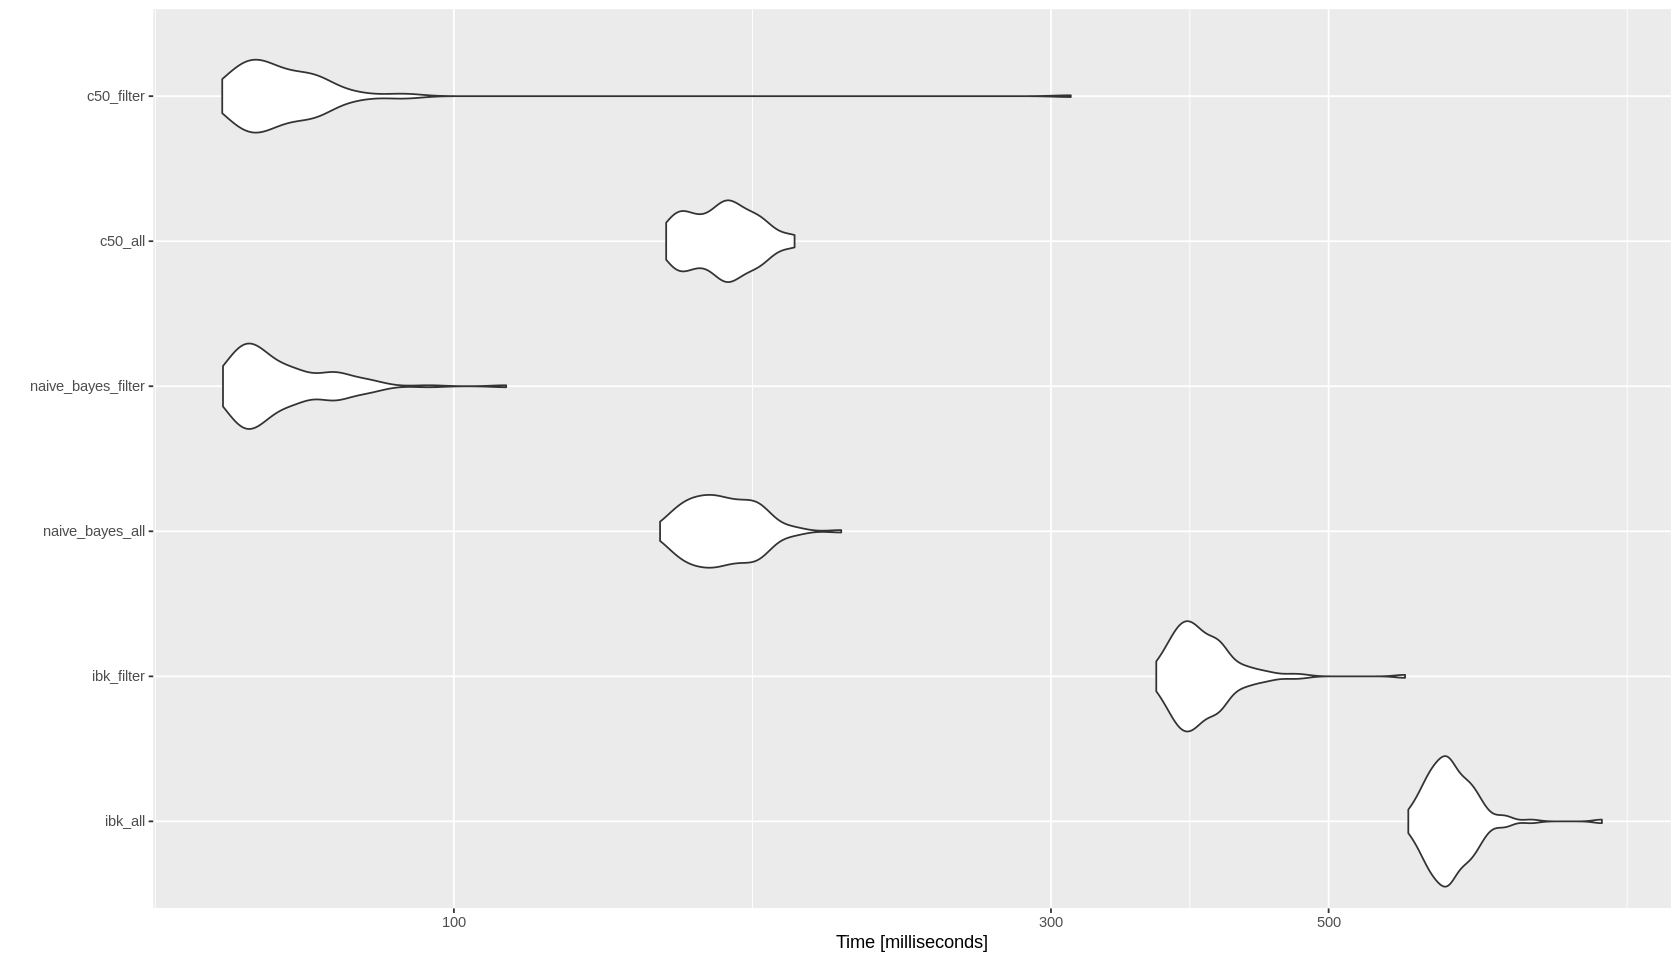

In [46]:
# ploting betchmark results
library(ggplot2);
autoplot(mb);

### Conclusiones de las pruebas de rendimiento

En proceso de entrenamiento fue más rápido para todos los modelos (IBk, Naïve Bayes y C5.0) cuando se usó un subconjunto de atributos especialmente elegido mediante *feature selection*.

El rendimiento de los modelos Naïve Bayes y C50 es similar en términos de tiempos de ejecución, situandose el tiempo de ejecución en torno a los 140 ms para el entrenamiento con todos los atributos y 50 ms para el entrenamiento con un subconjunto de los mismos.

Por otro lado IBk parece ser varias veces más lento que los anteriores, con tiempos de ejecución por encima de los 600 ms para todos los atributos y en torno a los 400 ms para un subconjunto de atributos.

Las diferencias de tiempo de ejecución entre usar todos los atributos y un subconjunto de los mismos para un mismo modelo es obvia ya que el uso de menos atributos conlleva directamente la realización de un menor número de operaciones.

Esta diferencia entre el rendimiento de los distintos modelos puede deberse a que tanto las implementaciones de Naïve Bayes y C50 usadas en esta práctica son librerías nativas en lenguaje R, que posiblemente usan código optimizado en C, mientras que la implementación de IBk está escrita originalmente en Java por el proyecto Weka y no cuenta con el grado de optimización de las librerías R.

## Conclusiones
TODO